In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import glob

In [2]:
car = glob.glob('train/vehicles/**/*.png', recursive=True)
noCar = glob.glob('train/non-vehicles/**/*.png', recursive=True)
print (len(car))
print (len(noCar))

carImg = []
noCarImg = []
for fname in car:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_RGB2BGR)
    carImg.append(img)
    
for fname in noCar:
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_RGB2BGR)
    noCarImg.append(img)
    
noCarImg[0] = cv2.cvtColor(cv2.imread("zzzz.png"), cv2.COLOR_RGB2BGR)

8792
9118


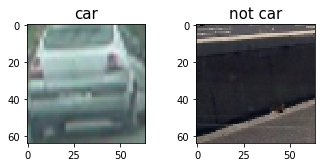

In [3]:
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))
f.tight_layout()
ax1.imshow(carImg[0])
ax1.set_title('car', fontsize=15)
ax2.imshow(noCarImg[0])
ax2.set_title('not car', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

In [4]:
print (noCarImg[0].shape)

(64, 64, 3)


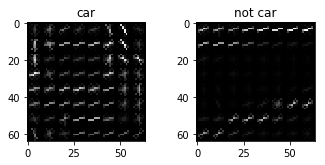

In [5]:
from skimage.feature import hog
pix_per_cell = 8
cell_per_block = 2
orient = 9

def get_hog_features(img, _orient, _pix_per_cell, _cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")
        return features
    
features, hog_car = get_hog_features( cv2.cvtColor(carImg[0], cv2.COLOR_RGB2GRAY), _orient=orient,
                _pix_per_cell=(pix_per_cell, pix_per_cell), 
                _cell_per_block=(cell_per_block, cell_per_block),  
                vis=True, feature_vec=True)
features, hog_noCar = get_hog_features(cv2.cvtColor(noCarImg[0], cv2.COLOR_RGB2GRAY), _orient=orient,
                _pix_per_cell=(pix_per_cell, pix_per_cell), 
                _cell_per_block=(cell_per_block, cell_per_block),  
                vis=True, feature_vec=True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 3))
f.tight_layout()
ax1.imshow(hog_car,'gray')
ax1.set_title('car' )
ax2.imshow(hog_noCar,'gray')
ax2.set_title('not car')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [6]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_spatial_features(imgs, cspace='HSV', spatial_size=(8, 8),
                        hist_bins=32, hist_range=(0, 256)):
    features = []
    for image in imgs:
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spatial_features, hist_features)))
    return features

In [7]:
   
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, _feature_vec = True):
    features = []
    for image in imgs:
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=_feature_vec))
            if _feature_vec:    
                hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=_feature_vec)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

In [8]:
print (np.array(extract_features(carImg[0:1], cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, _feature_vec = True)).shape)
print (np.array( extract_spatial_features(carImg[0:1])).shape)



(1, 5292)
(1, 288)


In [9]:
carFe1 = extract_features(carImg, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
carFe2 = extract_spatial_features(carImg)

noCarFe1 = extract_features(noCarImg, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
noCarFe2 = extract_spatial_features(noCarImg)

In [10]:
print (np.array(carFe1).shape)
print (np.array(carFe2).shape)
print (np.array(noCarFe1).shape)
print (np.array(noCarFe2).shape)


(8792, 5292)
(8792, 288)
(9118, 5292)
(9118, 288)


In [11]:
from sklearn.preprocessing import StandardScaler
# Fit a per-column scaler
X1 = np.vstack((np.array(carFe1), np.array(noCarFe1))).astype(np.float64)      
X2 = np.vstack((np.array(carFe2), np.array(noCarFe2))).astype(np.float64)      

X1_scaler = StandardScaler().fit(X1)
X2_scaler = StandardScaler().fit(X2)
scaled_X = np.concatenate((X1_scaler.transform(X1), X2_scaler.transform(X2)), axis = 1)

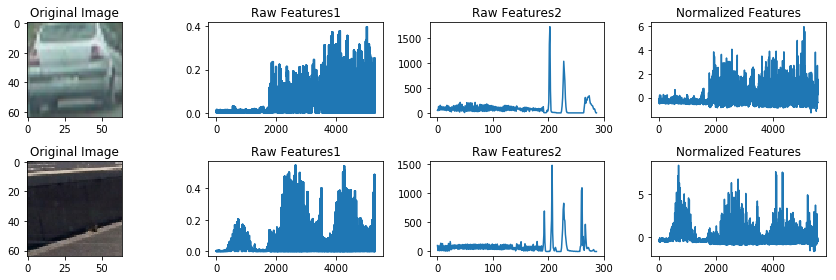

In [12]:
fig = plt.figure(figsize=(12,4))
plt.subplot(241)
plt.imshow(carImg[0])
plt.title('Original Image')
plt.subplot(242)
plt.plot(carFe1[0])
plt.title('Raw Features1')
plt.subplot(243)
plt.plot(carFe2[0])
plt.title('Raw Features2')
plt.subplot(244)
plt.plot(scaled_X[0])
plt.title('Normalized Features')

plt.subplot(245)
plt.imshow(noCarImg[0])
plt.title('Original Image')
plt.subplot(246)
plt.plot(X1[8792])
plt.title('Raw Features1')
plt.subplot(247)
plt.plot(X2[8792])
plt.title('Raw Features2')
plt.subplot(248)
plt.plot(scaled_X[8792])
plt.title('Normalized Features')
fig.tight_layout()

In [13]:
from sklearn.externals import joblib

joblib.dump(X1_scaler, 'X1_scaler.pkl') 
joblib.dump(X2_scaler, 'X2_scaler.pkl') 

['X2_scaler.pkl']

In [9]:
from sklearn.externals import joblib
X1_scaler = joblib.load('X1_scaler.pkl') 
X2_scaler = joblib.load('X2_scaler.pkl') 

In [10]:
import sklearn
print (sklearn.__version__)

0.18.2


In [16]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split


y = np.hstack((np.ones(len(carFe1)), np.zeros(len(noCarFe1))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5580
21.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9874
My SVC predicts:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  0.  0.  0.  0.  0.  0.  1.  0.]
0.00292 Seconds to predict 10 labels with SVC


In [17]:
from sklearn.externals import joblib

joblib.dump(svc, 'svcModel.pkl') 

['svcModel.pkl']

In [10]:
from sklearn.externals import joblib
svc = joblib.load('svcModel.pkl') 

In [21]:
from sklearn import svm 
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('rbf',), 'C':[10,50]}
svr = svm.SVC()
clf = GridSearchCV(svr, parameters, n_jobs = 2)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'kernel': ('rbf',), 'C': [10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
print( clf.cv_results_)

{'param_C': masked_array(data = [10 50],
             mask = [False False],
       fill_value = ?)
, 'rank_test_score': array([2, 1], dtype=int32), 'std_train_score': array([ 0.00130649,  0.00022829]), 'std_fit_time': array([ 5.96877325,  1.46824258]), 'split0_train_score': array([ 0.98458452,  0.99630451]), 'split1_test_score': array([ 0.96473818,  0.96473818]), 'mean_test_score': array([ 0.95812218,  0.95981137]), 'std_score_time': array([ 17.8345597 ,   0.49873274]), 'split0_test_score': array([ 0.95461262,  0.95883471]), 'param_kernel': masked_array(data = ['rbf' 'rbf'],
             mask = [False False],
       fill_value = ?)
, 'split1_train_score': array([ 0.98500845,  0.99619932]), 'mean_score_time': array([ 61.04037801,  24.62076863]), 'mean_fit_time': array([ 86.05095029,  55.43333101]), 'split2_test_score': array([ 0.95501584,  0.95586061]), 'mean_train_score': array([ 0.98571217,  0.99641046]), 'params': ({'kernel': 'rbf', 'C': 10}, {'kernel': 'rbf', 'C': 50}), 'split2_trai

In [23]:
print(clf.best_params_)
print('Test Accuracy of clf = ', round(clf.score(X_test, y_test), 4))
t=time.time()
n_predict = 10
print('My clf predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with clf')

{'kernel': 'rbf', 'C': 50}
Test Accuracy of clf =  0.9659
My clf predicts:  [ 0.  1.  1.  1.  1.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  1.  0.  1.  0.  1.  0.]
0.0711 Seconds to predict 10 labels with clf


In [12]:
clf=svc

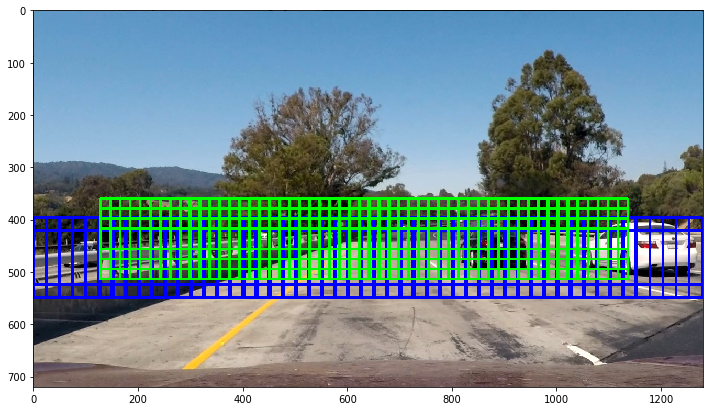

In [77]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

test_imgs = glob.glob('test_images/*.jpg', recursive=True)

img = cv2.cvtColor(cv2.imread(test_imgs[0]), cv2.COLOR_RGB2BGR)
h,w = img.shape[:2]

windows0 = slide_window(img, x_start_stop=[int(w*2/10), int(8*w/10)], y_start_stop=[int(h/2), int(6.5*h/10)], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))  
windows1 = slide_window(img, x_start_stop=[int(w*1/10), int(9*w/10)], y_start_stop=[int(h*5/10), int(7.25*h/10)], 
                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))  
windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=[int(h*5.5/10), int(7.75*h/10)], 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))    
windows3 = slide_window(img, x_start_stop=[None, None], y_start_stop=[int(h*6/10), int(9*h/10)], 
                    xy_window=(160, 160), xy_overlap=(0.8, 0.8))
windows4 = slide_window(img, x_start_stop=[None, None], y_start_stop=[int(h*5.5/10), int(8.5*h/10)], 
                    xy_window=(192, 192), xy_overlap=(0.8, 0.8))
windows5 = slide_window(img, x_start_stop=[None, None], y_start_stop=[int(h/2), int(h)], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))    
                       

allWindows = [windows2,windows1 ]
img = draw_boxes(img, windows2, color=(0, 0, 255), thick=4) 
# img = draw_boxes(img, windows3, color=(255, 0, 0), thick=4) 
img = draw_boxes(img, windows1, color=(0, 255, 0), thick=4)    
    
plt.figure(figsize = (12,8))
plt.imshow(img)

In [78]:
def search_windows2(img, windows, clf, X_scaler1, X_scaler2, orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0,):

    #1) Create an empty list to receive positive detection windows
    on_windows = []

    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features1 = np.array(extract_features([test_img], cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, _feature_vec = True))[0]
        
        test_features1 = X_scaler1.transform(np.array(features1).reshape(1, -1))
#         print(test_img.shape, test_img.dtype)
        features2 = np.array(extract_spatial_features([test_img]))[0]

        
        test_features2 = X_scaler2.transform(np.array(features2).reshape(1, -1).astype(float))
#         print("feature shape: ",test_features1.shape, test_features2.shape,
#              np.concatenate((test_features1, test_features2), axis = 1).shape)
        prediction = clf.predict(np.concatenate((test_features1, test_features2), axis = 1))
        if prediction == 1:
            on_windows.append(window)
#             plt.figure()
#             plt.imshow(img[window[0][1]:window[1][1],
#                         window[0][0]:window[1][0]
#                     ])
    return on_windows

0.85159 Seconds to search with whole hog
2.4002 Seconds to search with individual hog
0.84854 Seconds to search with whole hog
2.36279 Seconds to search with individual hog
0.80262 Seconds to search with whole hog
2.27919 Seconds to search with individual hog
0.82188 Seconds to search with whole hog
2.23575 Seconds to search with individual hog
0.82944 Seconds to search with whole hog
2.31323 Seconds to search with individual hog
0.80677 Seconds to search with whole hog
2.26453 Seconds to search with individual hog


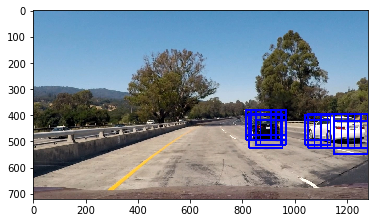

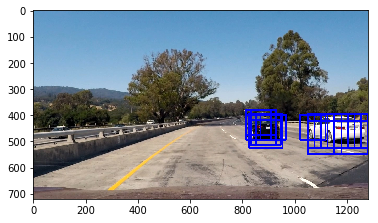

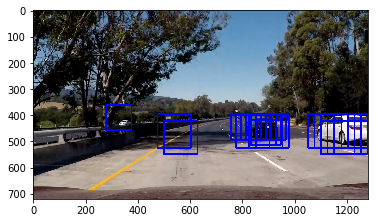

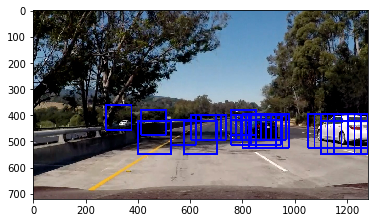

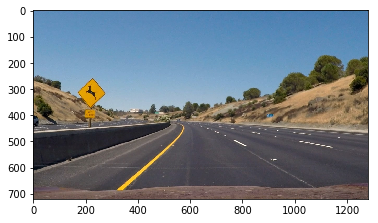

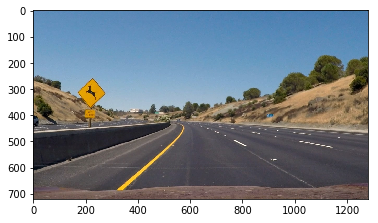

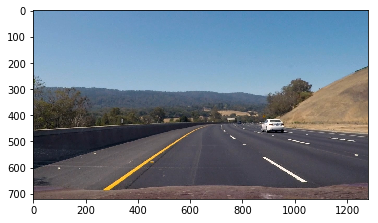

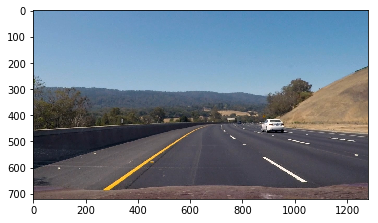

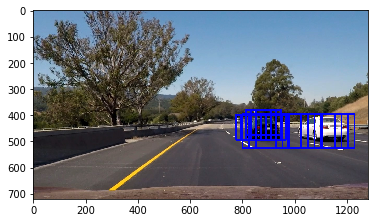

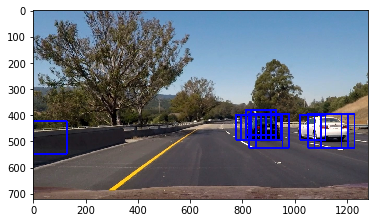

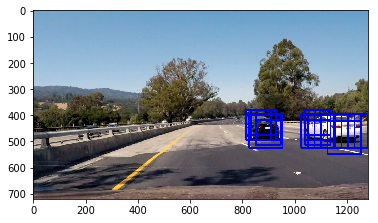

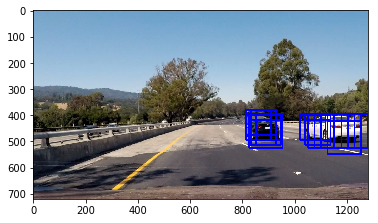

In [79]:
import time
def search_windows(img, windows, clf, X_scaler1, X_scaler2, orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0,):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    h,w = img.shape[:2]
    windowsize = windows[0][1][1] - windows[0][0][1]
    ratio = windowsize / 64
#     print (ratio)
    test_img = cv2.resize(img[int(h/2):, :], (int(w/ratio), int(h/ratio/2)))  
    featuresWhole = np.array(extract_features([test_img], cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, _feature_vec = False))[0]

    
#     print ("whole feature: ",featuresWhole.shape, len(windows))
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features1 = featuresWhole[:, 
                                 int(round((window[0][1] - int(h/2))/ratio/pix_per_cell)): 
                                 int(round((window[0][1] - int(h/2))/ratio/pix_per_cell)) + 7 ,
                                 int(round(window[0][0]/ratio/pix_per_cell)): 
                                 int(round(window[0][0]/ratio/pix_per_cell)) + 7 ] 
#         print("feature cut: ",int((window[0][1] - int(h/2))/ratio/pix_per_cell),
#                                  int((window[0][1] - int(h/2))/ratio/pix_per_cell) + 7 ,
#                                  int(window[0][0]/ratio/pix_per_cell),
#                                  int(window[0][0]/ratio/pix_per_cell) + 7 )
#         print("feature shape: ",features.shape)
        features1 = np.ravel(features1)
        test_features1 = X_scaler1.transform(np.array(features1).reshape(1, -1))
        
#         print ("submig",   window[0][1],window[1][1],
#                                             window[0][0],window[1][0])    
        features2 = np.array(extract_spatial_features([
                                    cv2.resize(img[
                                            window[0][1]:window[1][1],
                                            window[0][0]:window[1][0]
                                            ],(64,64))
                                    ]))[0]

        
        test_features2 = X_scaler2.transform(np.array(features2).reshape(1, -1).astype(float))
#         print("feature shape: ",test_features1.shape, test_features2.shape,
#              np.concatenate((test_features1, test_features2), axis = 1).shape)
        prediction = clf.predict(np.concatenate((test_features1, test_features2), axis = 1))
        if prediction == 1:
            on_windows.append(window)
#             plt.figure()
#             plt.imshow(img[window[0][1]:window[1][1],
#                         window[0][0]:window[1][0]
#                     ])
    return on_windows



def search_windows_multi(img, windows_multi, clf, X_scaler1, X_scaler2, orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0,_search = search_windows):
    on_windows=[]
    for win in windows_multi:
    
        hot_windows = _search(img, win 
                            , clf, X_scaler1, X_scaler2, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, hog_channel = hog_channel)  
        on_windows += hot_windows
    return on_windows
    
hot_windows = None
    
for test_img in test_imgs:
    img = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_RGB2BGR)
    t=time.time()    
    hot_windows = search_windows_multi(img, allWindows 
                            , clf, X1_scaler, X2_scaler,  
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, hog_channel="ALL")                       

    img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)                    
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to search with whole hog')
    plt.figure()
    plt.imshow(img)
    
    img = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_RGB2BGR)
    t=time.time()    
    hot_windows = search_windows_multi(img, allWindows 
                            , clf, X1_scaler, X2_scaler,  
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, hog_channel="ALL",_search= search_windows2)                       

    img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)                    
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to search with individual hog')
    plt.figure()
    plt.imshow(img)
#     break;
    

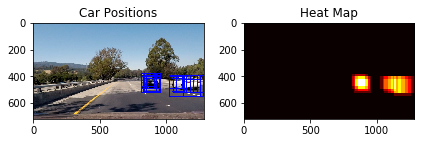

In [80]:

from scipy.ndimage.measurements import label


heat = np.zeros_like(img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
# heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
heat = np.zeros_like(img[:,:]).astype(np.float)

In [81]:
timeheat = np.zeros_like(img[:,:,0]).astype(np.float)
mod = 6
i = 0
heatArray = np.tile(timeheat[None,:,:],(mod,1,1))

debug = False

def process_image(img):
    #return should be a color image (3 channel) 
    hot = search_windows_multi(img, allWindows 
                            , clf, X1_scaler, X2_scaler,
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, hog_channel="ALL")
    
    
    global timeheat
    global mod
    global i
    global heatArray
#     print (np.sum(timeheat), len(hot))
    timeheat = np.zeros_like(img[:,:,0]).astype(np.float)
    timeheat = add_heat(timeheat,hot)
    
    if debug:
        fig = plt.figure(figsize=(10,10))
        plt.subplot(131)
        plt.title('Car Positions')
        window_img = draw_boxes(img, hot, color=(0, 0, 255), thick=6)                    
        plt.imshow(window_img)
    
    heatArray[i] = timeheat;
    i = (i + 1)%mod;
    avgHeat = np.mean(heatArray,axis = 0)
    
    avgHeat = apply_threshold(avgHeat,4)

    labels = label(avgHeat)
    draw_img = draw_labeled_bboxes(img, labels)

    if debug:
        plt.subplot(132)
        plt.imshow(timeheat, cmap='hot')
        plt.title('current Heat Map')
        plt.subplot(133)
        plt.imshow(avgHeat, cmap='hot')
        plt.title('Avg threshhold Heat')
        fig.tight_layout()
#         print (timeheat[450:460,1050:1060])
        
#         plt.figure()
#         plt.imshow(draw_img)


    return draw_img

from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_out.mp4'


clip1 = VideoFileClip("project_video.mp4")#.subclip(31,31.5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [18:18<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 21min 26s, sys: 6.09 s, total: 21min 33s
Wall time: 18min 19s


In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))